In [1]:
import pandas as pd
import numpy as np
import re
import xgboost
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords    
stop_words = set(stopwords.words('english'))
import xgboost as xgb
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.pipeline import Pipeline
import pickle

In [2]:
data=pd.read_csv('C:/Users/HP/Desktop/corona_fake.csv')

In [3]:
data.head(10)

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake
5,CORONA UNMASKED: Chinese Intelligence Officer ...,NaN,NaN,NaN
6,NaN,Urgent: Health Bulletin to the Public. Ministr...,Ministry of Health,Fake
7,NaN,"Pls tell ur families, relatives and friendsMOH...",NWLLAB,Fake
8,NaN,SERIOUS EXCELLENT ADVICE by Japanese doctors t...,Japanese doctors treating COVID-19 cases,Fake
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,TRUE


In [4]:
data['label'].value_counts()

TRUE    584
Fake    346
fake    230
Name: label, dtype: int64

In [5]:
#replace lable value "fake" and "Fake" with "Not Genuine"
# and "True" with "Genuine"

data["label"]= data["label"].str.replace("fake", "Fake ", case = False)

In [6]:
data["label"]= data["label"].str.replace("Fake", "Fake ", case = False)

In [7]:
data['label'].value_counts()

TRUE      584
Fake      576
Name: label, dtype: int64

In [8]:
data["label"]= data["label"].str.replace("True", "Genuine", case = False)

In [9]:
data['label'].value_counts()

Genuine    584
Fake       576
Name: label, dtype: int64

In [10]:
#check if column lable has null value
label_column=data['label'].isnull()
label_column

0       False
1       False
2       False
3       False
4       False
        ...  
1160    False
1161    False
1162    False
1163    False
1164    False
Name: label, Length: 1165, dtype: bool

In [11]:
#find the row which has lable column null
for i in range (1164):
    if(label_column[i]==True):
        print(i)

5
15
43
131
242


In [12]:
#replace lable column null values
data.loc[5]['label'] = 'Fake'
data.loc[15]['label'] = 'Genuine'
data.loc[43]['label'] = 'Fake'
data.loc[131]['label'] = 'Genuine'
data.loc[242]['label'] = 'Fake'

In [13]:
data.isnull().sum()

title     82
text      10
source    21
label      0
dtype: int64

In [14]:
#replace null values with blank 
data=data.fillna(' ')

In [15]:
print(data.isnull().sum())

title     0
text      0
source    0
label     0
dtype: int64


In [16]:
# Combine text and title column to 

data['textdata']=data['text']+' '+data['title']
print(data['textdata'][0])

You just need to add water, and the drugs and vaccines are ready to be administered. There are two parts to the kit: one holds pellets containing the chemical machinery that synthesises the end product, and the other holds pellets containing instructions that telll the drug which compound to create. Mix two parts together in a chosen combination, add water, and the treatment is ready. Due to the recent outbreak for the Coronavirus (COVID-19) the World Health Organization is giving away vaccine kits. Just pay $4.95 for shipping


In [17]:
#Removing punctuations and converting data to lowercase¶
data['textdata'] = data['textdata'].str.replace('[^\w\s]','')
data['textdata'] = data['textdata'].str.lower()

In [18]:
data['textdata'][0]

'you just need to add water and the drugs and vaccines are ready to be administered there are two parts to the kit one holds pellets containing the chemical machinery that synthesises the end product and the other holds pellets containing instructions that telll the drug which compound to create mix two parts together in a chosen combination add water and the treatment is ready due to the recent outbreak for the coronavirus covid19 the world health organization is giving away vaccine kits just pay 495 for shipping'

In [19]:
stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [20]:
def func_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize 
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming 
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation 
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [21]:
import nltk
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [22]:
data['total'] = data['textdata'].apply(lambda x: func_preprocess_text(x))

In [23]:
data.head(10)

,title,text,source,label,textdata,total
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake,you just need to add water and the drugs and v...,you just need to add water and the drug and va...
1,,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake,hydroxychloroquine has been shown to have a 10...,hydroxychloroquine ha been shown to have a 100...
2,,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake,fact hydroxychloroquine has been shown to have...,fact hydroxychloroquine ha been shown to have ...
3,,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake,the corona virus is a man made virus created i...,the corona virus is a man made virus created i...
4,,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake,doesnt billgates finance research at the wuhan...,doesnt billgates finance research at the wuhan...
5,CORONA UNMASKED: Chinese Intelligence Officer ...,,,Fake,corona unmasked chinese intelligence officer...,corona unmasked chinese intelligence officer r...
6,,Urgent: Health Bulletin to the Public. Ministr...,Ministry of Health,Fake,urgent health bulletin to the public ministry ...,urgent health bulletin to the public ministry ...
7,,"Pls tell ur families, relatives and friendsMOH...",NWLLAB,Fake,pls tell ur families relatives and friendsmoh ...,pls tell ur family relative and friendsmoh hea...
8,,SERIOUS EXCELLENT ADVICE by Japanese doctors t...,Japanese doctors treating COVID-19 cases,Fake,serious excellent advice by japanese doctors t...,serious excellent advice by japanese doctor tr...
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,Genuine,stay aware of the latest information on the co...,stay aware of the latest information on the co...


In [24]:
data = data.drop("textdata", axis=1)

In [25]:
data['total'][100]

'every virology lab in the world that ha run a genomic analysis of the coronavirus now know that the coronavirus wa engineered by human scientist the proof is in the virus itself the tool for genetic insertion are still present a remnant in the genetic code since these unique gene sequence dont occur by random chance theyre proof that this virus wa engineered by scientist in a lab but the who and cdc are covering up this inconvenient fact in order to protect communist china and it biological weapon program since no government want the public to know the full truth about how frequently governmentrun lab experience outbreak decade ago for example the u army ran an ebola bioweapon lab in the united state where a monkey infected one of the scientist there the strain turned out to be infectious only in monkey not human so the world dodged a bullet but the u army nuked the entire facility with chemical bomb killing all the monkey and wiping out any last remnant of the virus on u soil you can

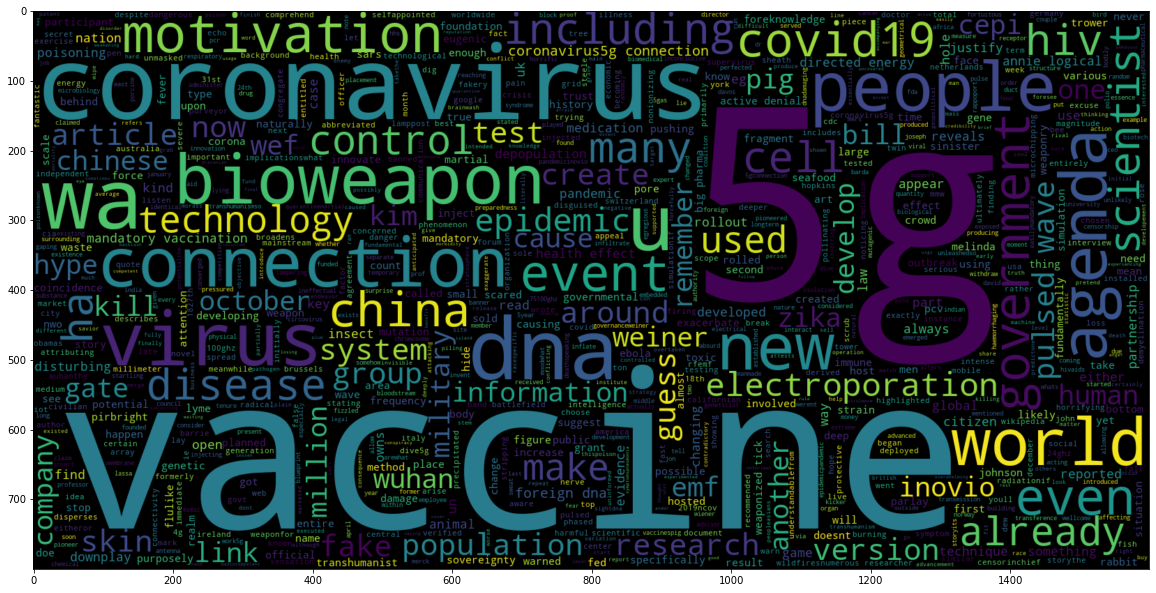

In [26]:
#word cloud vizualization 

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == "Fake"].total))
plt.imshow(wc, interpolation = 'bilinear')

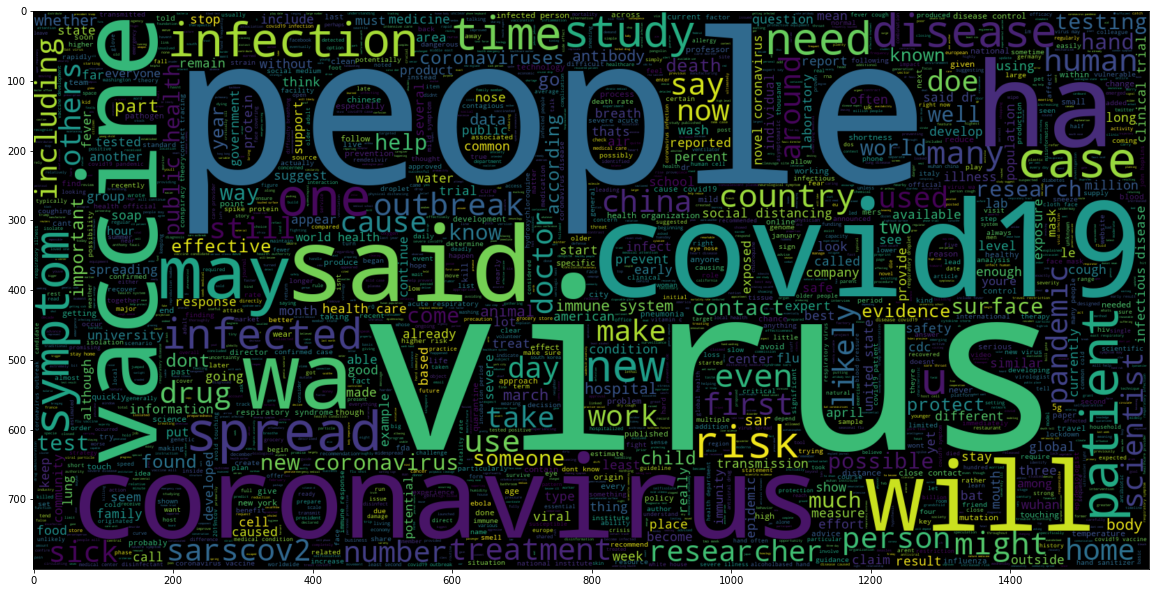

In [27]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == "Genuine"].total))
plt.imshow(wc, interpolation = 'bilinear')

In [28]:
#split the data in train and test 

y=data.label
y

0        Fake  
1        Fake  
2        Fake  
3        Fake  
4        Fake  
         ...   
1160    Genuine
1161    Genuine
1162    Genuine
1163    Genuine
1164     Fake  
Name: label, Length: 1165, dtype: object

In [29]:
data.drop("label", axis=1,inplace=True)

In [30]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data['total'], y, test_size=0.2,random_state=102)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(932,) (932,)
(233,) (233,)


In [32]:
# Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test  = tfidf_vectorizer.transform(X_test)

In [33]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.80)  
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [34]:
xgb_model = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
xgb_model.fit(tfidf_train, y_train)
pred3 = xgb_model.predict(tfidf_test)

print('Accuracy of XGBoost on test set:',accuracy_score(y_test, pred3))


Accuracy of XGBoost on test set: 0.8841201716738197


In [35]:
pac = XGBClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

XGBClassifier(max_iter=50, objective='multi:softprob')

In [36]:
print("Classification Report for XGBoost Model: \n", metrics.classification_report(y_test, pred3))

Classification Report for XGBoost Model: 
               precision    recall  f1-score   support

      Fake         0.90      0.88      0.89       126
     Genuine       0.86      0.89      0.88       107

    accuracy                           0.88       233
   macro avg       0.88      0.88      0.88       233
weighted avg       0.88      0.88      0.88       233



confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


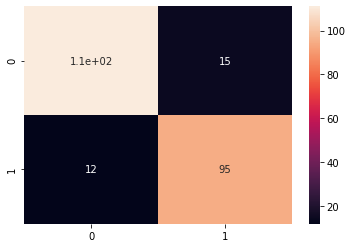

In [37]:
cm = confusion_matrix(y_test, pred3)
import seaborn as sns

print("confusion matrix: \n", sns.heatmap(cm, annot = True))

In [38]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.80)),
    ('clf',xgb_model)])

In [39]:
pipeline = Pipeline([
    ('tfid', TfidfVectorizer(stop_words='english', max_df=0.80)),
    ('pac',xgb_model)])

In [40]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfid', TfidfVectorizer(max_df=0.8, stop_words='english')),
                ('pac',
                 XGBClassifier(colsample_bytree=0.6, objective='multi:softprob',
                               random_state=42, seed=2, subsample=0.7))])

In [41]:
from pprint import pprint
print('Parameters Used:\n')
pprint(xgb_model.get_params())

Parameters Used:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 2,
 'silent': None,
 'subsample': 0.7,
 'verbosity': 1}


In [42]:
with open('tfid.pickle','wb') as f:
    pickle.dump(tfidf_vectorizer,f)
    

In [43]:
# saving model
with open('model_fakenews.pickle','wb') as f:
    pickle.dump(pac,f)

In [44]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.80)),
    ('clf',xgb_model)])

In [45]:
with open('model.pickle', 'wb') as handle:
    pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(pipeline, open("tfidf.pickle", "wb"))